In [14]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

# e.g. City_id = 1, using selected data

In [68]:
import pandas as pd
selected_df = pd.read_csv("filtered_data_city1.csv", sep='\t', header=0)
selected_df = selected_df[selected_df["city_id"]==1]
selected_df.head(3)

,date_event,type,value,city_id,timestamp,date,time,weekday,tdelta,tdelta_min
0,2023-07-04 22:12:39,0,0.105000,1,2023-07-04 22:12:39,2023-07-04,22:12:39,2,0 days 00:00:02,0.033333
1,2023-07-10 12:25:05,0,0.020354,1,2023-07-10 12:25:05,2023-07-10,12:25:05,1,0 days 05:47:00,347.000000
2,2023-07-10 15:17:35,0,0.105000,1,2023-07-10 15:17:35,2023-07-10,15:17:35,1,0 days 02:52:30,172.500000


In [70]:
selected_df['unix_ts'] = pd.to_datetime(selected_df.timestamp).apply(lambda x: int(x.timestamp())).astype(int)

### datetime from 2023/7/11
selected_df = selected_df[selected_df['unix_ts']>=1689082398].reset_index(drop=True)
selected_df['hour_index'] = selected_df['unix_ts']//3600
selected_df['hour_index'] = selected_df['hour_index'] - selected_df['hour_index'].min()
# print(selected_df.head(3))

df = selected_df[['hour_index', 'value']]
# df['day'] = ((df.hour_index - 11) // 24 + 2) % 7 + 1 
# hard coded for knowing which day is the day according to initial hour_index
df = df.groupby(['hour_index']).mean().reset_index()

In [67]:
df

,hour_index,weekday,value
0,0,2.0,0.187787
1,1,2.0,0.404619
2,2,2.0,0.441498
3,3,2.0,0.724283
4,4,2.0,0.193599
...,...,...,...
266,347,3.0,0.218163
267,348,3.0,0.558570
268,352,3.0,0.262792
269,353,3.0,0.315643


In [151]:
pad_df = []
for h in  np.arange(0, df.hour_index.max()): # possible hour index
    matching_row = df[df['hour_index'] == h]
    v = matching_row['value'].values[0] if not matching_row.empty else 0
    day = ((h - 11) // 24 + 2) % 7 + 1 # calculate what day with hard coded formular according to initial hour
    pad_df.append([h, v, day]) # hour and value

pad_df = pd.DataFrame(pad_df, columns = ['hour_index', 'mean_value', 'day'])
pad_df

,hour_index,mean_value,day
0,0,0.187787,2
1,1,0.404619,2
2,2,0.441498,2
3,3,0.724283,2
4,4,0.193599,2
...,...,...,...
349,349,0.000000,3
350,350,0.000000,3
351,351,0.000000,3
352,352,0.262792,3


In [110]:
feat_df = pad_df.copy()
for i in range(1, 25):
    new_column_name = f'value_shift_{i}'
    feat_df[new_column_name] = feat_df['mean_value'].shift(i)
feat_df = feat_df.dropna().reset_index()
feat_df = pd.get_dummies(feat_df, columns=['day'], dtype=int)
feat_df

,index,hour_index,mean_value,value_shift_1,value_shift_2,value_shift_3,value_shift_4,value_shift_5,value_shift_6,value_shift_7,...,value_shift_22,value_shift_23,value_shift_24,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,24,24,0.365277,0.295500,0.333460,0.314829,0.402290,0.389791,0.330464,0.330314,...,0.441498,0.404619,0.187787,0,0,1,0,0,0,0
1,25,25,0.391379,0.365277,0.295500,0.333460,0.314829,0.402290,0.389791,0.330464,...,0.724283,0.441498,0.404619,0,0,1,0,0,0,0
2,26,26,0.440046,0.391379,0.365277,0.295500,0.333460,0.314829,0.402290,0.389791,...,0.193599,0.724283,0.441498,0,0,1,0,0,0,0
3,27,27,0.362597,0.440046,0.391379,0.365277,0.295500,0.333460,0.314829,0.402290,...,0.154464,0.193599,0.724283,0,0,1,0,0,0,0
4,28,28,0.243996,0.362597,0.440046,0.391379,0.365277,0.295500,0.333460,0.314829,...,0.214764,0.154464,0.193599,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,349,349,0.000000,0.558570,0.218163,0.428380,0.177547,0.212264,0.266966,0.244087,...,0.000000,0.000000,0.396077,0,0,1,0,0,0,0
326,350,350,0.000000,0.000000,0.558570,0.218163,0.428380,0.177547,0.212264,0.266966,...,0.297351,0.000000,0.000000,0,0,1,0,0,0,0
327,351,351,0.000000,0.000000,0.000000,0.558570,0.218163,0.428380,0.177547,0.212264,...,0.523222,0.297351,0.000000,0,0,1,0,0,0,0
328,352,352,0.262792,0.000000,0.000000,0.000000,0.558570,0.218163,0.428380,0.177547,...,0.294434,0.523222,0.297351,0,0,1,0,0,0,0


In [112]:
X

array([[0.29549973, 0.33345953, 0.31482915, ..., 0.        , 0.        ,
        0.        ],
       [0.36527707, 0.29549973, 0.33345953, ..., 0.        , 0.        ,
        0.        ],
       [0.39137898, 0.36527707, 0.29549973, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.55857047, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.26279178, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [111]:
X = feat_df.iloc[:, 3:].values
X.shape

(330, 31)

In [113]:
y = feat_df['mean_value'].values
y.shape

(330,)

# Start Training

In [126]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

size_X_train = X_train.shape[0]
for p in [5, 10, 20, 50, 100]:
    X_train_sub = X_train[:p*size_X_train//100]
    y_train_sub = y_train[:p*size_X_train//100]
    model = LinearRegression(fit_intercept=True)  # fit_intercept=True == bias
    model.fit(X_train_sub, y_train_sub)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print("Training Data Percentage        : %d%%"%p)
    print("Training Data Size              :", X_train_sub.shape[0])
    print("Mean Absolute Error on Test Set : %.4f \n"%mae)

    

Training Data Percentage        : 5%
Training Data Size              : 13
Mean Absolute Error on Test Set : 0.1849 

Training Data Percentage        : 10%
Training Data Size              : 26
Mean Absolute Error on Test Set : 0.2212 

Training Data Percentage        : 20%
Training Data Size              : 52
Mean Absolute Error on Test Set : 0.1772 

Training Data Percentage        : 50%
Training Data Size              : 132
Mean Absolute Error on Test Set : 0.1064 

Training Data Percentage        : 100%
Training Data Size              : 264
Mean Absolute Error on Test Set : 0.0953 



In [144]:
stat = []
for p in range(10,100):
    X_train_sub = X_train[:p*size_X_train//100]
    y_train_sub = y_train[:p*size_X_train//100]
    model = LinearRegression(fit_intercept=True)  # fit_intercept=True == bias
    model.fit(X_train_sub, y_train_sub)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    stat.append([p, mae])
stat = np.array(stat)

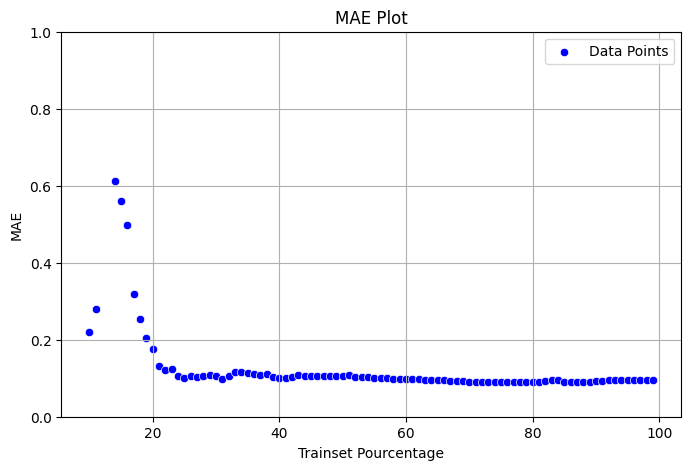

In [162]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=stat[:,0], y=stat[:,1], color='blue', label='Data Points')
plt.title('MAE Plot')
plt.xlabel('Trainset Pourcentage')
plt.ylabel('MAE')
plt.ylim(0, 1)  # 设置 y 轴的限制
plt.legend()
plt.grid(True)
plt.show()

(0.0, 1.0)

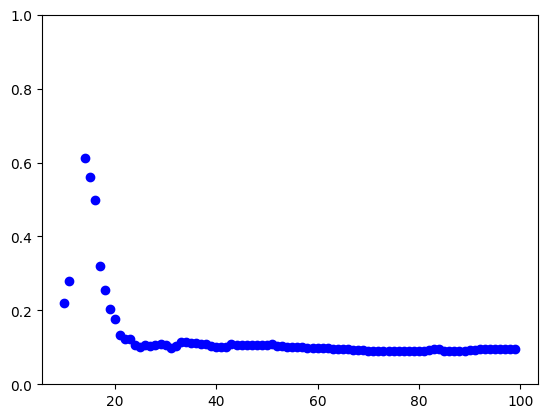

In [145]:
plt.scatter(stat[:,0], stat[:,1], c='blue', label='Data Points')
plt.ylim(0,1)

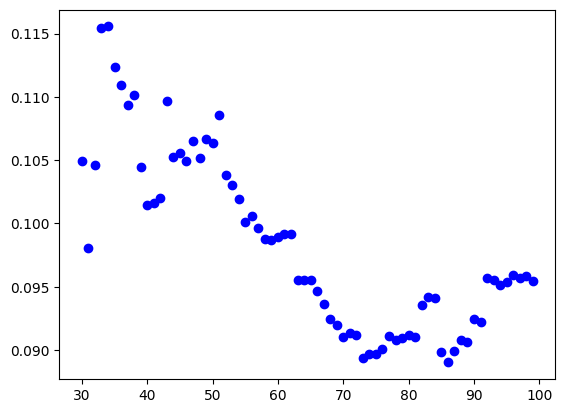

In [149]:
plt.scatter(stat[20:,0], stat[20:,1], c='blue', label='Data Points')

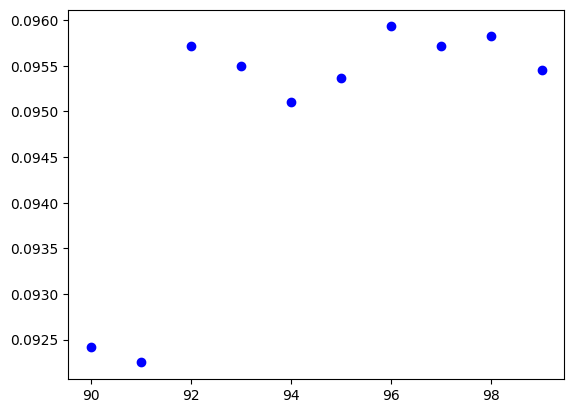

In [150]:
plt.scatter(stat[80:,0], stat[80:,1], c='blue', label='Data Points')